<a href="https://colab.research.google.com/github/vrnTEK/Deep-Learning/blob/master/Graded_Assignment_1_MNIST_classifier_using_numpy_and_python_without_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating MNIST Classifier using Numpy
###Goal is to use plain feed forward NNs without keras NN library but just numpy  (you can use keras only for image augmentation and getting training set and nothing else)
Following are the tasks that needs to be accomplished by the code:

1. The code should normalize the input as discussed in the class before training (scaling the input) 
2. The code should do mini batch gradient descent along with appropriate learning
3. The code should do dropout - try various dropout rates and pick the one which works well. (need not be same for all layers)
4. The code should initialize the random weights of network properly
5. The code should do basic image augmentations to supplement the training data (not testing data) using keras libraries
6. The code should use  3 or more layers for training (not 2 as in example ) - you have to tune and pick number of neurons in your layer and number of layers
7. The code will continue to use relu activation layer in right places like python code
8. The code should use appropriate learning rate (try out few to find out which one works) - you can use adaptive learning rates like different learning rates per epoch or per mini batch
9. The code should provide appropriate metrics, visualization,  testing and training accuracy etc.,. and plot the results and confusion matrix  (this is important)
10. The code should display top common errors images identified incorrectly
11. Extra points if you hit 99% test accuracy with these changes (very challenging given you are not using CNNs).


##Importing the Libraries required

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

####Importing Libraries for image augmentation

In [0]:
import warnings
warnings.filterwarnings('ignore')
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

####Importing Mnist dataset from Keras Library dataset as suggested by Professor

In [3]:
#Loading the Mnist dataset from Keras dataset
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


###Converting images to numpy array for easy calculation

Also checking the shape and dimentions in the numpy array defined

In [4]:
x_train = np.vstack([img.reshape(-1,) for img in mnist.train.images])
y_train = mnist.train.labels

x_test = np.vstack([img.reshape(-1,) for img in mnist.test.images])
y_test = mnist.test.labels
x_train.shape

(55000, 784)

In [7]:
"""x_train = np.float32(mnist['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)
x_test  = np.float32(MNIST_data['x_test'][:])
y_test  = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)"""

"x_train = np.float32(mnist['x_train'][:])\ny_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)\nx_test  = np.float32(MNIST_data['x_test'][:])\ny_test  = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)"

Now we have a 2 dimentional numpy array with 60000 rows with 784 (28 X 28) features of data in other two dimentions. We can now carry out the normalization of the data.

There is also an alternative method as well that we can follow:

The difference is that this will yield 3-dimentional array which needs to be reshaped into 2-D

  * from tensorflow.keras.datasets import mnist:
  * (x_train, y_train), (x_test, y_test) = mnist.load_data()
  * Converting training data to Numpy array
  * mnist_train = np.array(x_train)
  * mnist_trtarget = np.array(y_train)
  * Coverting test data to Numpy array
  * mnist_test = np.array(x_test)
  * mnist_tetarget = np.array(y_test)

###Prininting first record to check the values and range of features

In [8]:
"""import pprint
pp = pprint.PrettyPrinter(width=100, compact = True)
pp.pprint(mnistd_train[48000])"""

'import pprint\npp = pprint.PrettyPrinter(width=100, compact = True)\npp.pprint(mnistd_train[48000])'

###One Hot Encoding and data Transforming

As we can see from the above values that there are many zero values for pixels which are not activated this is something we need to avoid since weights dont update well for zero values. we will add 0.001 to the result

In [9]:
X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
X.shape

(65000, 784)

###Encoding Output label as well with one hot encoding

Encoding Y training and Y test labels for entire dataset

In [10]:
# one-hot encoding
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

"digits = 10\nexamples = mnistar_train.shape[0]\nmnistar_train = mnistar_train.reshape(1, examples)\nY_train = np.eye(digits)[mnistar_train.astype('int32')]\nY_train = Y_train.T.reshape(digits, examples)"

In [0]:
#Redundant Code To be deleted

#digits = 10
#examples = mnistar_train.shape[0]
#mnistar_train = mnistar_train.reshape(1, examples)
#Y_train = np.eye(digits)[mnistar_train.astype('int32')]
#Y_train = Y_train.T.reshape(digits, examples)

#digits = 10
#examples = mnistar_test.shape[0]
#mnistar_test = mnistar_test.reshape(1, examples)
#Y_test = np.eye(digits)[mnistar_test.astype('int32')]
#Y_test = Y_test.T.reshape(digits, examples)

In [0]:
# number of training set
m = 55000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:, :m], Y_new[:, m:]

In [0]:
# shuffle training set
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

#X_transpose = X_train[:].T #redundant code for checking the data orientation
#X_transpose.shape

###Displaying the output for training data 

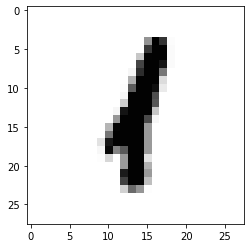

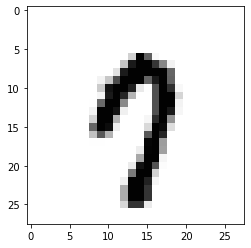

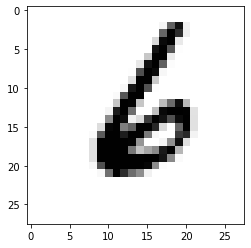

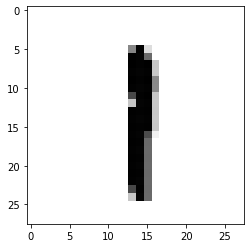

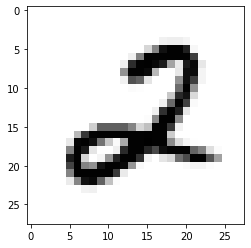

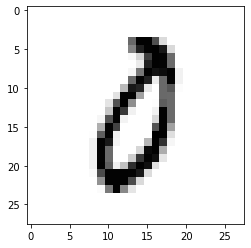

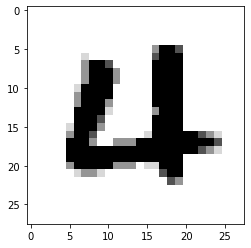

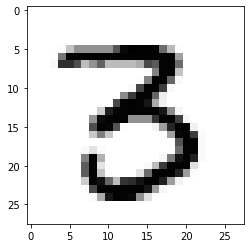

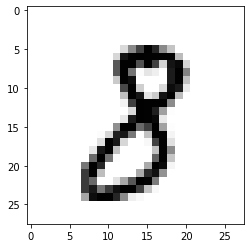

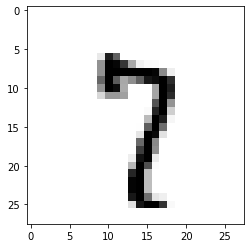

In [14]:
for i in range(10):
    img = X_train[::,i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

###Saving the data in a pickle file for quick access and caching of data in RAM

In [0]:
import pickle

with open("pickled_mnist.pkl", "bw") as fh:
    data = (train_imgs, 
            test_imgs, 
            Y_train,
            Y_test,)
    pickle.dump(data, fh)

In [0]:
with open("pickled_mnist.pkl", "br") as fh:
    data = pickle.load(fh)

train_imgs = data[0]
test_imgs = data[1]
Y_train = data[2]
Y_test = data[3]

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

### Creating a Classifier Artificial Neural Network

####Creating the Sigmoid function class as defined in slides

In [0]:
@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activation_function = sigmoid

In [0]:
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)

####Simple Neural network creation without multiple epochs, bias

In [0]:
class NeuralNetwork:
  def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
  def create_weight_matrices(self):
        """ 
        A method to initialize the weight matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))
        
    
  def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
        

        
    
  def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
            
  def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

  def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
  def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
        
    
  def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [0]:
ANN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
    
    
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], Y_train[i])